# Analysis of attention heads 

This notebook is intended to identify how the trained model works to distinguish between neutralizing and non-neutralizing antibodies that binds to the target antigen. 

In [16]:
import torch 
from torch.utils.data import DataLoader
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from math import ceil 
from scipy.stats import ttest_ind

from covbind_esm2_struct import CovBind_ftESM as esm2_struct 
from covbind_esm2_struct import SequenceDataset as esm2_struct_dataset


In [4]:
# Load pretrained model and test data 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model_savepath = 'saved_models/covbind_ESM2_Struct_ft.pth' 
model = esm2_struct() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 
model = model.eval() 

df_test = pd.read_csv('data/test_data.csv') 

/Users/faisal/_RESEARCH/__Ongoing/CovAbDab/covbind_esm2_struct.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.vh_model.load_state_dict(torch.load('Pretrained/ESM2

In [5]:
# Function to generate attention matrices for given heavy and light chain seuqneces. 
def get_vh_vl_attentions(df1):
    dataset_test = esm2_struct_dataset(df1['Antibody VH'].tolist(), 
                            df1['Antibody VL'].tolist(),
                            df1['Target'].tolist(),
                            df1['Binding'].tolist())
    data_loader = DataLoader(dataset_test, batch_size=8, shuffle=True)

    vh_attns = []   
    vl_attns = []   
    with torch.no_grad():
        for vh_ids,  vl_ids, ag_embs, labels in data_loader:
            vh_ids = vh_ids.to(device) 
            vl_ids = vl_ids.to(device)
            ag_embs = ag_embs.to(device) 
            labels = labels.to(device)
            vh_attn, vl_attn = model(vh_ids, vl_ids, ag_embs, return_attn=True)
            print(vh_attn.shape)
            vh_attns.append(vh_attn) 
            vl_attns.append(vl_attn) 

    vh_attns = torch.cat(vh_attns, dim=0)
    vl_attns = torch.cat(vl_attns, dim=0)
    
    return vh_attns, vl_attns 


In [22]:
# Function to analyse attention matrices for given attentions of two group of antibodies. 
def analyse_attentions(vh_att_0, vh_att_1): 
    """
    Args:
        vh_att_0 (_type_): attentions from negative class samples 
        vh_att_1 (_type_): attentions from positive class samples 
    """
    # ----------------------------------------------------------------------------
    #  Compute class‐mean attention maps
    # ----------------------------------------------------------------------------
    vh_mean1 = vh_att_0.mean(axis=0)   # → (L, H, S, S)
    vh_mean2 = vh_att_1.mean(axis=0)

    L, H, S, _ = vh_mean1.shape 

    # flatten each head/map into a vector of length S*S
    vh_means_flat1 = vh_mean1.reshape(L*H, S*S)
    vh_means_flat2 = vh_mean2.reshape(L*H, S*S)

    # stack both classes if you want PCA over the union
    vh_all_means = np.vstack([vh_means_flat1, vh_means_flat2])  # shape (2·L·H, S*S)

    print(f"attentions tensor shape: {vh_all_means.shape}")

    # ----------------------------------------------------------------------------
    #  Rank heads by class‐difference (Frobenius norm of mean1−mean2)
    # ----------------------------------------------------------------------------
    diff = vh_mean1 - vh_mean2                      # (L, H, S, S)
    fro_norms = np.linalg.norm(diff.reshape(L*H, -1), axis=1)
    # sort indices descending by ∥Δ∥
    ranked_heads = np.argsort(-fro_norms)

    print(f"Ranking of attention heads (first 100): {ranked_heads[:100]}")

    # ----------------------------------------------------------------------------
    # Per‐element t-tests to find significantly different (i,j) pairs
    # ----------------------------------------------------------------------------
    # flatten per‐example maps to shape (Ni, L·H, S*S)
    n1 = vh_att_0.shape[0]
    n2 = vh_att_1.shape[0]
    vh_flat1 = vh_att_0.reshape(n1, L*H, S*S)
    vh_flat2 = vh_att_1.reshape(n2, L*H, S*S)

    # t-test along the example axis, for each head and each (i,j)
    t_stats = np.zeros((L*H, S*S))
    p_vals  = np.ones_like(t_stats)

    for idx in range(L*H):
        t, p = ttest_ind(vh_flat1[:, idx, :], vh_flat2[:, idx, :], axis=0)
        t_stats[idx] = t
        p_vals[idx]  = p

    p_thresh = 0.05 
    # mask of “significant” entries
    sig_mask = p_vals < p_thresh
    # you can reshape sig_mask[idx] back to (S,S) to see which positions differ in head idx

    return diff, ranked_heads, sig_mask 

In [50]:
# Plot the attention differences of the selected heads. 

# IMGT boundaries for heavy chain (0-based indexing):
# FR1: 0–25, CDR1: 26–38, FR2: 39–55, CDR2: 56–65, FR3: 66–104, CDR3: 105–111
IMGt_BOUNDS = [27, 40, 55, 65, 98, 106]


def plot_attention_diff(diff, selected_heads, sig_mask, savepath="attentions.pdf" ):
    n_plot = len(selected_heads) 
    if n_plot < 7:
        n_row = ceil(n_plot/3)  
        fig, axs = plt.subplots(n_row, 3, figsize=(10, 5*n_row))  # wider, less tall
    else:
        n_row = ceil(n_plot/4) 
        fig, axs = plt.subplots(n_row, 4, figsize=(20, 5*n_row))  # wider, less tall
        
    axs = axs.flatten()

    # Precompute global color scale across all heads for consistency
    L, H, S, _ = diff.shape  
    all_diff = diff.reshape(L * H, S, S)[580:600].numpy()
    global_vmax = np.max(np.abs(all_diff))
    global_vmin = -global_vmax 
    
    
    for i, head_idx in enumerate(selected_heads):
        diff_map = diff.reshape(L * H, S, S)[head_idx].numpy()
        mask = sig_mask.reshape(L * H, S, S)[head_idx]
        layer = head_idx // 20 + 1
        head = head_idx % 20 + 1

        diff_crop = diff_map[:112, :112]
        mask_crop = mask[:112, :112]

        ax = axs[i]
        im = ax.imshow(
            diff_crop,
            cmap="bwr_r",
            vmin=global_vmin,
            vmax=global_vmax,
            aspect='equal'
        )

        ys, xs = np.where(mask_crop)
        ax.scatter(
            xs, ys,
            s=5,
            facecolors='none',
            edgecolors='k',
            linewidths=0.2,
            alpha=0.9,
            label=f"p < 0.05"  # ← add label here
        )

        for b in IMGt_BOUNDS:
            ax.axhline(b + 0.5, color='k', linewidth=0.15)
            ax.axvline(b + 0.5, color='k', linewidth=0.15)

        ax.set_title(f"Layer {layer} Head {head}", fontsize=10)
        ax.set_xlabel("Key (amino acid) Position")
        ax.set_ylabel("Query (amino acid) Position")
        # ax.set_xticks()
        # ax.set_yticks()

        # ax.legend(loc='upper right', markerscale=1)

    # Automatically tighten subplot layout
    plt.tight_layout(rect=[0, 0.01, 1, 1])  # leave space at bottom for colorbar

    # Add text box above the colorbar
    
    if n_plot>6: 
        fig.text(
            0.5, 0.01,  # x, y (centered, slightly above colorbar at 0.05)
            f'(p < 0.05 shown as hollow circles)',
            ha='center', va='center', fontsize=10
        )
         # Add horizontal colorbar below plots
        cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.005])  # [left, bottom, width, height]
    else:
        fig.text(
            0.5, 0.12,  # x, y (centered, slightly above colorbar at 0.05)
            f'(p < 0.05 shown as hollow circles)',
            ha='center', va='center', fontsize=10
        )
         # Add horizontal colorbar below plots
        cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
        

   
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

    plt.savefig(savepath, dpi=1000)

    plt.show()



In [23]:
# Get data from two neutralizing classes for a selected target. 

cond1 = (df_test['Binding']==1) & (df_test['Neutralizing']==0)
cond2 = (df_test['Binding']==1) & (df_test['Neutralizing']==1)
cond3 = (df_test['Target']=="sars-cov2-omicron-ba2") 

df1 = df_test[cond1 & cond3] 
df2 = df_test[cond2 & cond3] 

vh_att_0, vl_att_0 = get_vh_vl_attentions(df1) 
vh_att_1, vl_att_1 = get_vh_vl_attentions(df2) 



/Users/faisal/_RESEARCH/__Ongoing/CovAbDab/covbind_esm2_struct.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.tg_embs = torch.load('data/target_embeddings.pt')


torch.Size([8, 30, 20, 230, 230])
torch.Size([5, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([5, 30, 20, 230, 230])
attentions tensor shape: (1200, 52900)
Ranking of attention heads (first 100): [463 202 384 445 350 472 288 313 279 162 343 402 454 266 585 423 414 372
 318 285 377 551 367 353 196 272 405 396 168 437  43 468 393 175 397 359
 369 436 322 302 226 408 150 215 428 236 357 483 361 229 354 295 374 115
 315 328 143 431 292 257 365 341 363 404 246 470 577 234 185 371 340 286
 136 296 308 378 342 133 242 479 532 481 390 368 305 413  98 203 379 165
 153 123 151 334 309 156 346 339 388 415]


attentions tensor shape: (1200, 52900)
Ranking of attention heads (first 100): [463 202 384 445 350 472 288 313 279 162 343 402 454 266 585 423 414 372
 318 285 377 551 367 353 196 272 405 396 168 437  43 468 393 175 397 359
 369 436 322 302 226 408 150 215 428 236 357 483 361 229 354 295 374 115
 315 328 143 431 292 257 365 341 363 404 246 470 577 234 185 371 340 286
 136 296 308 378 342 133 242 479 532 481 390 368 305 413  98 203 379 165
 153 123 151 334 309 156 346 339 388 415]


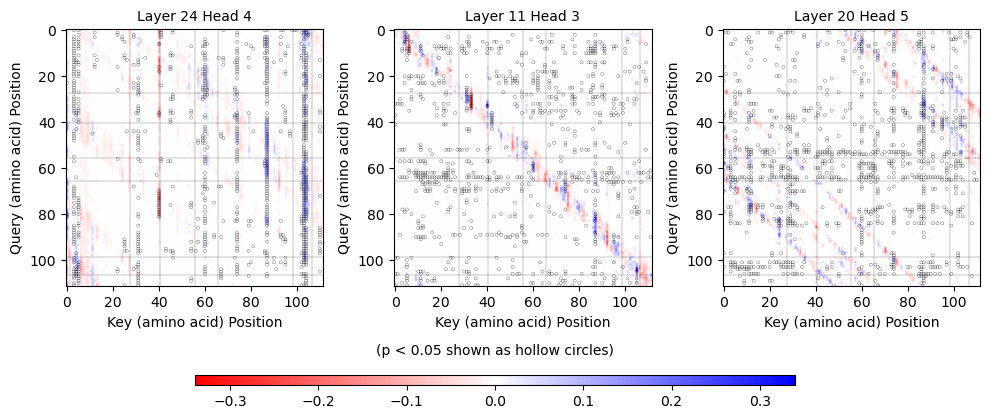

In [54]:
# ANALYSING HEAVY CHAIN SEQUENCES 
diff, ranked_heads, sig_mask = analyse_attentions(vh_att_0, vh_att_1) 
plot_attention_diff(diff, ranked_heads[:3], sig_mask, 'vh_attentions.pdf')


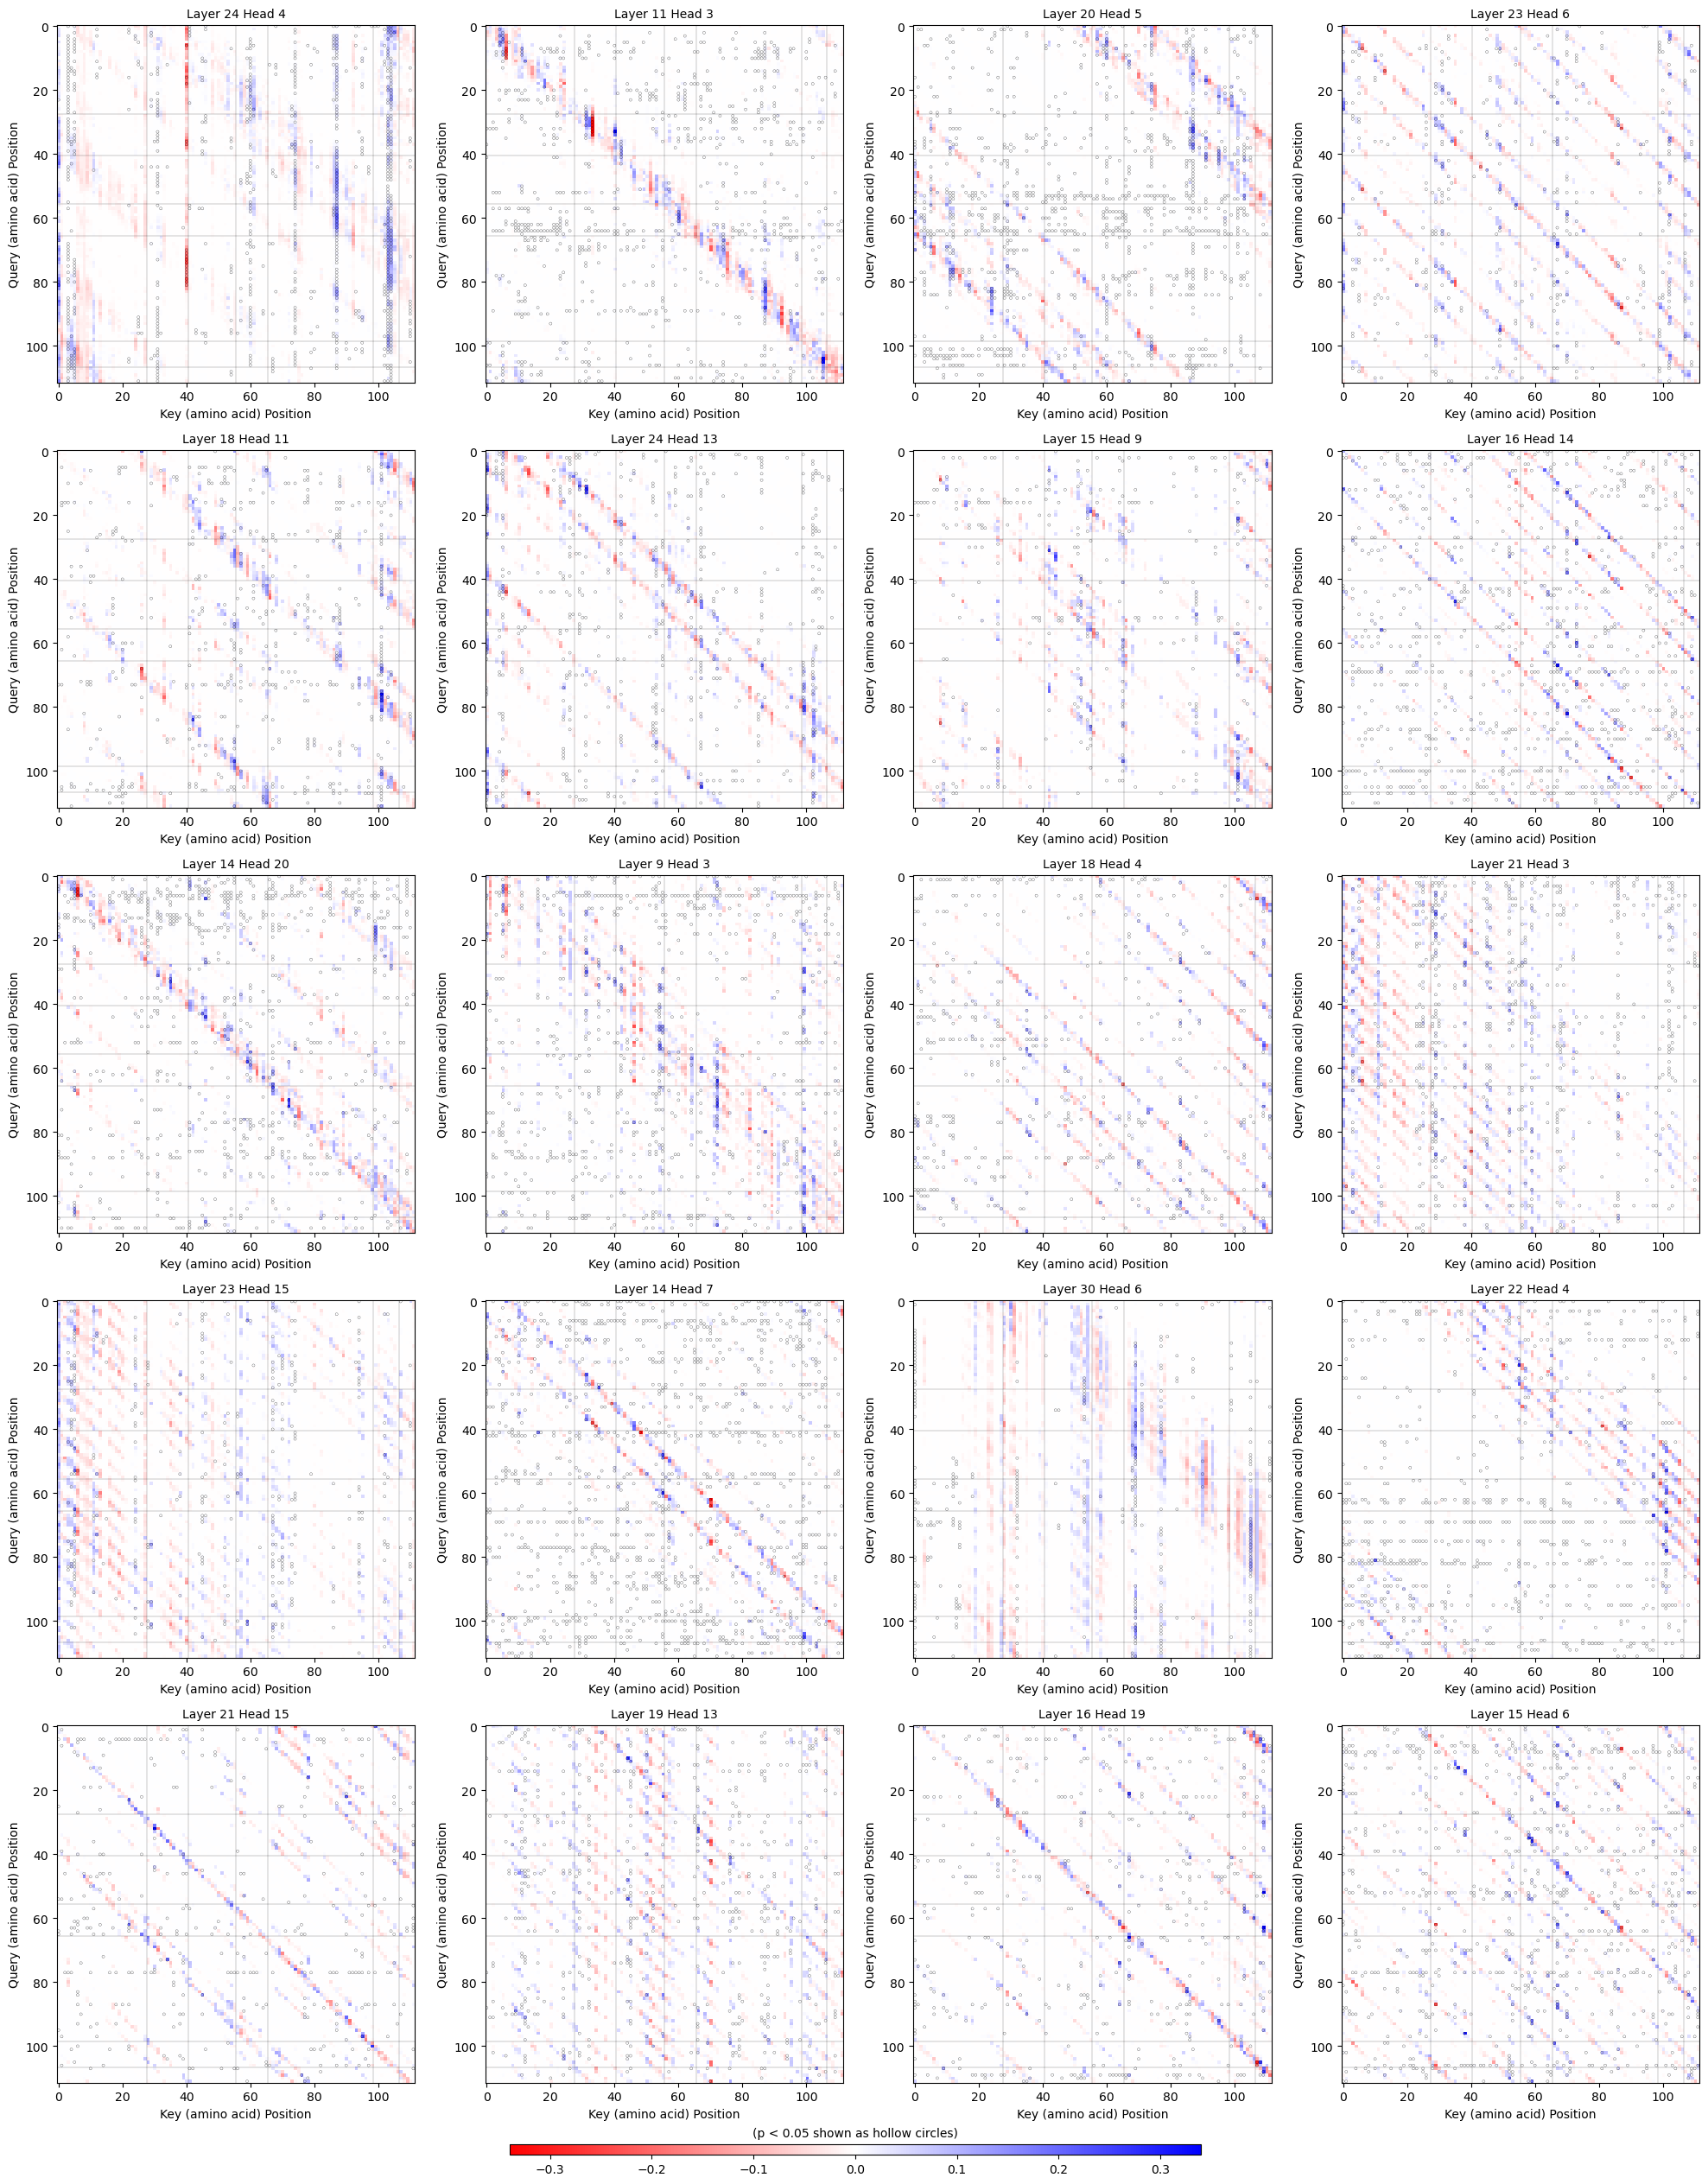

In [55]:
# Top 20 significant attention heads  for heavy chain seqs. 

plot_attention_diff(diff, ranked_heads[:20], sig_mask, 'vh_attentions_top20.pdf')


attentions tensor shape: (1200, 47961)
Ranking of attention heads (first 100): [304 107 221 366 106 184  73 146 120 134  85 130  97  77  71 192 169 175
  11 198 183 269 186 218 131 389 135  86   6  81 113 197 331 247 150 117
 167 160  96  48 254 101 122  83  12  90 309 205 173 274  94 303 121  19
 358 220 283 118 347 258 231 136   2 164  15 174 262 278 250   0 217 109
 367 375  98   3 381 312 159 299 168 165 163  93  49 267  13 311 176 154
 310 431 229 171 126  76 199 298 226 105]


/Users/faisal/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


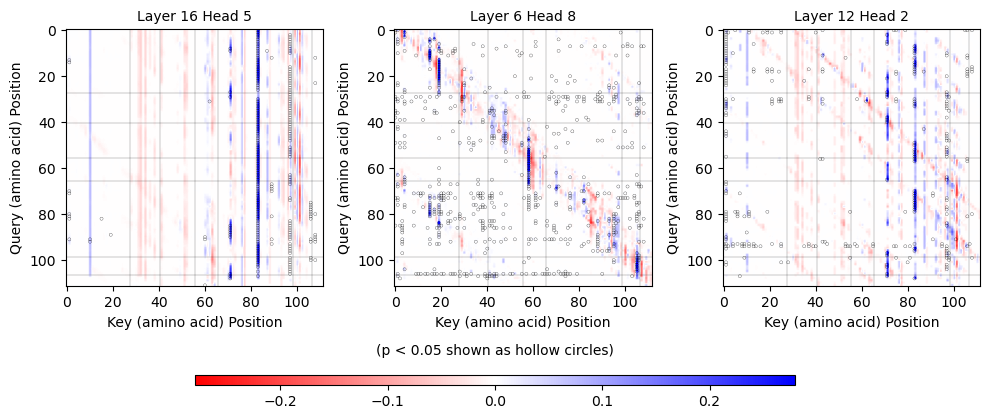

In [52]:
# ANALYSING HEAVY CHAIN SEQUENCES 
diff, ranked_heads, sig_mask = analyse_attentions(vl_att_0, vl_att_1)
plot_attention_diff(diff, ranked_heads[:3], sig_mask, 'vl_attentions.pdf')



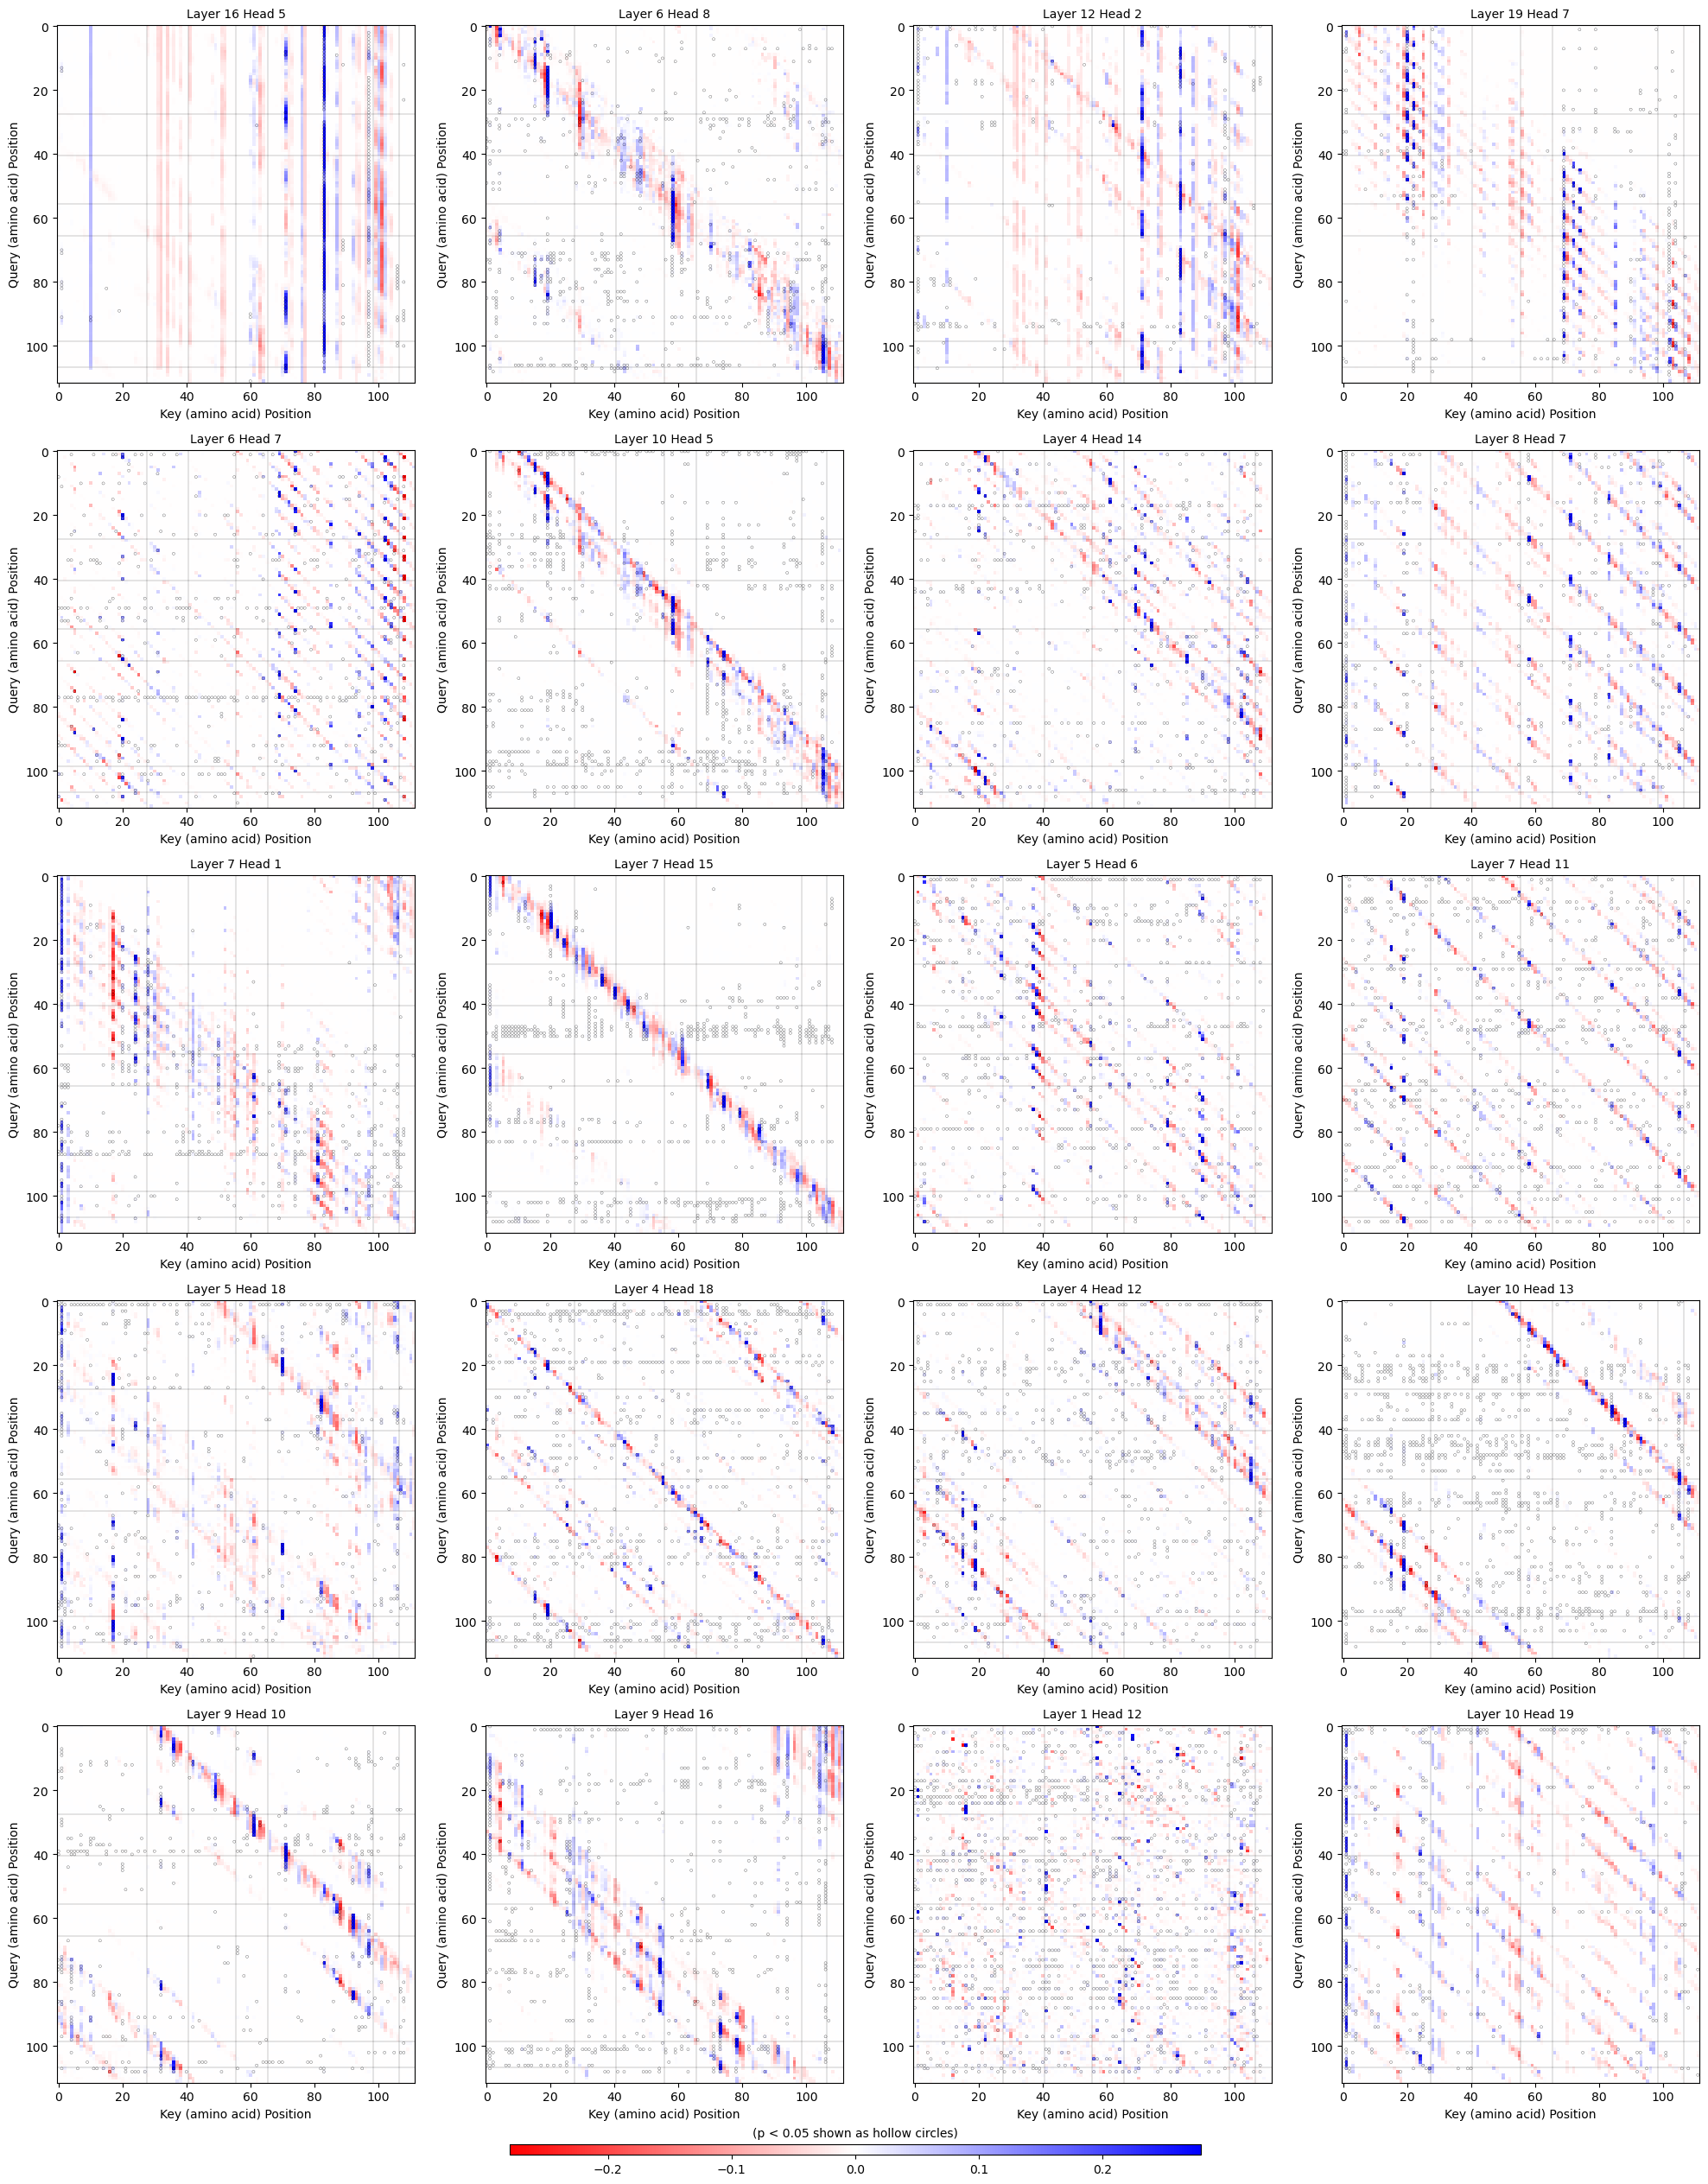

In [53]:
# Top 20 significant attention heads for light chain seqs. 

plot_attention_diff(diff, ranked_heads[:20], sig_mask, 'vl_attentions_top20.pdf')
